# Drug Discovery

This is a demo to explore potential drugs on [A single-cell atlas of the peripheral immune response in patients with severe COVID-19 data](https://www.nature.com/articles/s41591-020-0944-y) based on BRICK.

## Load packages and data

In [2]:
import sklearn
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.read('../Virus_Pertubation/Original_Data/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad')
adata

AnnData object with n_obs × n_vars = 44721 × 26361
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'singler'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'matrix', 'norm_data', 'scale_data'

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


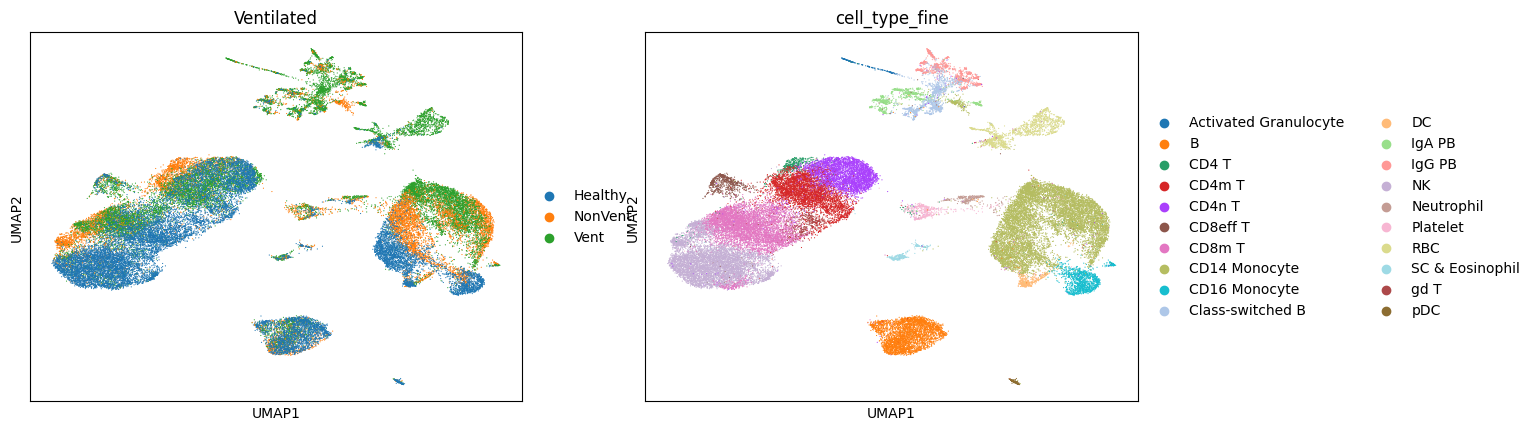

In [4]:
sc.pl.umap(adata, color = ['Ventilated', 'cell_type_fine'])

## Differential Expression Gene analysis

Here we take **CD14 monocyte** as example and calculate diffferential expression gene both on celltype and cell state. With top DEG number as 100, the final Geneset is composed of 100 DEG for CD14 monocyte as well as for Healthy, NonVert and Vent in CD14 monocyte respectively.

In [ ]:
select_celltype = 'Neutrophil'
N_top_genes = 100

geneset = set()

# 100 DEG from CD14 monocyte
sc.tl.rank_genes_groups(adata, 'cell_type_fine')
BRICK.pp.rank_genes_groups2df(adata)
for x in list(adata.uns['rank_genes_groups_df'][select_celltype]['names'])[:N_top_genes]:
    geneset.add(x)

# 100 DEG from different cell state of monocyte
adata_sub = adata[adata.obs['cell_type_fine'] == select_celltype].copy()
sc.tl.rank_genes_groups(adata_sub, 'Ventilated')
BRICK.pp.rank_genes_groups2df(adata_sub)
for cell_state in adata_sub.uns['rank_genes_groups_df'].values():
    for x in list(cell_state['names'])[:N_top_genes]:
        geneset.add(x)

print(len(geneset))

## Query Knowledge Graph

this might some time because gene might related to many entities.

In [ ]:
df = BRICK.qr.query_neighbor(geneset, source_entity_type='Gene',
                             target_entity_type=['Disease','Phenotype',
                                                 'Process','Cell_Component','Pathway', 'Function',
                                                 'Tissue','Cell',
                                                 'Chemical','Stage'], return_type='triplet')

## Filter target entity 
by pvalue with cut-off as 0.01

In [3]:
df_count = BRICK.rk.enrich(df)
df_count_filtered = df_count.loc[df_count['pvalue'] < 0.01]
df_count_filtered.head()

,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
25,"[ISG15, CD36, CD163, KLF4, CD83, SOCS3, MBD2, ...",CHEBI:4806,(-)-epigallocatechin 3-gallate,Chemical,50,1788,0.002535
79,"[MBD2, SELL, NR4A2, IRF1, MAPK14]",CHEBI:35628,(6-methoxy-2-naphthyl)acetic acid,Chemical,5,55,0.003955
87,"[H6PD, CD36, PPIG, SAT1, THBS1, SOD2, NCF1, PT...",CHEBI:58968,(E)-4-hydroxynon-2-enal,Chemical,31,914,0.000986
94,"[JUND, JUNB, JUN, FOSB, FOS]",CHEBI:28985,"(R)-1,2-epoxypropane",Chemical,5,13,0.000011
137,"[KLF4, PTEN, JUND, JUNB, JUN, FOSB, FOS, CDKN1A]",CHEBI:34019,(S)-ATPA,Chemical,8,82,0.000189


## Construct Graph 
Construct Graph with adata and queried df from Knowledge Graph

In [5]:
# abort
select_celltype = 'NK'
adata_sub = sc.read(f'./data/{select_celltype}.h5ad')
geneset = set(adata_sub.uns['query_gene_set'])

In [3]:
geneset

{'ABLIM1',
 'AC009501.4',
 'ACTB',
 'ACTG1',
 'ACTR3',
 'ADAR',
 'ADD3',
 'AHNAK',
 'AKAP13',
 'ALOX5AP',
 'ANXA1',
 'ANXA5',
 'APOL6',
 'ARL4C',
 'ARRDC3',
 'ATHL1',
 'ATP5E',
 'B2M',
 'BCL2',
 'BIN2',
 'BST2',
 'C1orf173',
 'C1orf63',
 'CALR',
 'CAP1',
 'CAPZA1',
 'CASP1',
 'CCR1',
 'CCR5',
 'CD247',
 'CD38',
 'CD3D',
 'CD3E',
 'CD3G',
 'CD53',
 'CFL1',
 'CIRBP',
 'CLIC3',
 'CMPK2',
 'CNOT6L',
 'COPB2',
 'CTSC',
 'CTSW',
 'CX3CR1',
 'CXXC5',
 'DDX5',
 'DDX60',
 'DDX60L',
 'DHX58',
 'DIP2A',
 'DNAJA1',
 'DTX3L',
 'EEF1A1',
 'EEF1D',
 'EEF2',
 'EIF2AK2',
 'EIF4B',
 'EPSTI1',
 'ETS1',
 'FADS1',
 'FBL',
 'FGFBP2',
 'FGFR1OP2',
 'FGL2',
 'GBP1',
 'GBP5',
 'GIMAP4',
 'GLTSCR2',
 'GNB2L1',
 'GNLY',
 'GPBP1',
 'GZMA',
 'GZMB',
 'H3F3B',
 'HBA2',
 'HBB',
 'HELZ2',
 'HERC5',
 'HERC6',
 'HIST1H1C',
 'HLA-B',
 'HLA-C',
 'HLA-DPB1',
 'HLA-DRB1',
 'HLA-DRB5',
 'HLA-E',
 'HLA-F',
 'HSP90AA1',
 'HSPA8',
 'HSPD1',
 'HSPH1',
 'IER2',
 'IFI16',
 'IFI27',
 'IFI35',
 'IFI44',
 'IFI44L',
 'IFI6',
 'IFIH1'

In [6]:
# abort
import pickle

#select_celltype = 'Neutrophil'
with open(f'data/df_count_{select_celltype}.pickle', 'rb') as f:
    df_count = pickle.load(f)

df_count_filtered = df_count.loc[df_count['pvalue'] < 0.01]
df_count_filtered.head()



,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
60,"[CASP1, BCL2, IFI27, HLA-B, PYCARD, TXNIP]",CHEBI:71335,"(3R)-7,2'-dihydroxy-4'-methoxyisoflavanol",Chemical,6,96,0.005657
156,"[CD3D, TNFSF10, RUNX3, CASP1, CALR, LAP3, VIM,...",MMUSDV:0000045,1 week,Stage,44,1558,0.000590
201,"[PDIA4, TNFSF10, CASP1, CALR, APOL6, VIM, ACTG...",CHEBI:18320,"1,4-dithiothreitol",Chemical,23,806,0.008168
217,"[PIM1, IL32, CD3D, CASP1, LAP3, XIST, S100B, S...",MESH:D015632,"1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine",Chemical,28,997,0.004909
263,"[ISG15, CD38, IL32, CD3D, IQGAP1, TNFSF10, RUN...",GO:0016303,1-phosphatidylinositol-3-kinase activity,Function,82,3349,0.000524


In [4]:
nxg = BRICK.pp.combine_graph(adata_sub[:, list(geneset)], df_count_filtered)

print(len(nxg.nodes))

10176


In [5]:
adata_sub

AnnData object with n_obs × n_vars = 6857 × 26361
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'singler'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'Ventilated_colors', 'assay', 'authors', 'cell_type_fine_colors', 'disease', 'organism', 'preprint', 'query_gene_set', 'rank_genes_groups', 'rank_genes_groups_df', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'

In [44]:
model = BRICK.emb.GRACE_model(nxg, device='cuda:1')

(T):   0%|          | 0/5000 [00:00<?, ?it/s]/home/share/huadjyin/home/s_caolei2/yanbang/qiuping/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
(T): 100%|██████████| 5000/5000 [06:43<00:00, 12.38it/s, loss=7.51]


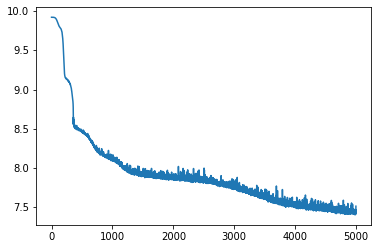

In [45]:
model.fit(epoches=5000)
model.plot_loss()

In [46]:
adata_graph = model.get_result()
adata_graph

/home/share/huadjyin/home/s_caolei2/yanbang/qiuping/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10176 × 32
    obs: 'name', 'type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [48]:
# abort

#adata_graph.write(f'./result_data/adata_graph_{select_celltype}_5000.h5ad')

In [7]:

adata_graph = sc.read(f'./result_data/adata_graph_{select_celltype}_5000.h5ad')

In [8]:
cell2celltype = dict(zip(adata_sub.obs_names, adata_sub.obs['Ventilated']))
adata_graph.obs['cellstate'] = [cell2celltype[x] if x in cell2celltype else y for x, y in zip(adata_graph.obs['name'], adata_graph.obs['type'])]

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


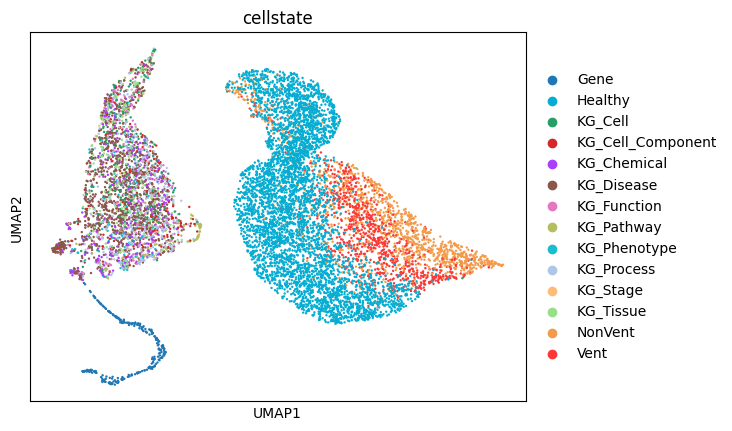

In [11]:
adata_graph.uns['cellstate_colors'] = ['#1f77b4','#06add2','#279e68','#d62728','#aa40fc',
                                       '#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8',
                                       '#ffbb78','#98df8a','#f39b4a','#FB3737']

sc.pl.umap(adata_graph, color = 'cellstate')

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


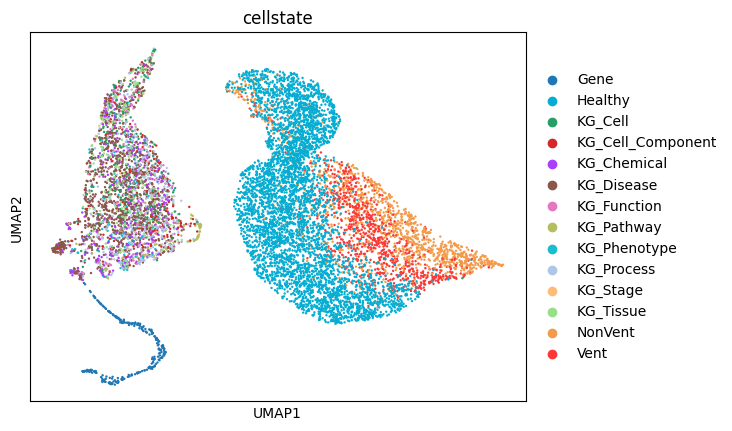

In [60]:
fig, ax = plt.subplots(1)
sc.pl.umap(adata_graph, color = 'cellstate', ax=ax)
fig.savefig('./result_data/Figure/Umap_DD_adata_graph_NK.pdf')

In [21]:
label2color = dict(zip(adata_graph.obs['cellstate'].cat.categories, adata_graph.uns['cellstate_colors']))

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

In [53]:
def multi_histo_plot(ret, xmin=0, xmax=10, ygap=0.45, title = 'Histoplot of F-score between timepoint', xlabel = 'log1p F score'):
    from scipy import stats
    fig = plt.figure(figsize = (4,10))
    ax = fig.subplots()
    
    X_plot = np.linspace(xmin, xmax, 100)
    
    baseline_rec = []
    baseline = 0
    
    d = {x:np.mean(y) for x,y in ret.items()}
    d = [x for x,y in sorted(d.items(),key=lambda x:x[1],reverse=False) ]
    flag_st = True
    flag_mf = True
    
    for x in d:
        print(x)
        baseline_rec.append(baseline)
        kde1 = stats.gaussian_kde(dataset=ret[x], bw_method='scott')
        Y_plot = kde1(X_plot) *10
        Y_plot = Y_plot + baseline

        ax.fill(np.append(X_plot, [X_plot[-1], X_plot[0]]), np.append(Y_plot,[baseline,baseline]), alpha =0.5, color = label2color['KG_'+x],  label=x)
               
        baseline += ygap
    ax.hlines(baseline_rec, [xmin]*len(baseline_rec), [xmax]*len(baseline_rec), color='black')
    ax.set_yticks(baseline_rec)
    ax.set_yticklabels(d)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend()
    return fig

In [32]:
y.head()

,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
336,"[XIST, ZFP36L2, EEF1D]",UBERON:0007232,2 cell stage,Tissue,3,152,0.437513
450,"[RPS2, BCL2, LBR, HSP90AA1, PABPC1]",UBERON:0019249,2-cell stage embryo,Tissue,5,757,0.991517
661,"[HSPA8, ADAR]",UBERON:0007233,4 cell stage,Tissue,2,89,0.417341
706,[MT2A],UBERON:0019251,4-cell stage embryo,Tissue,1,521,0.999705
866,"[PABPC1, ADAR]",UBERON:0007236,8 cell stage,Tissue,2,93,0.438684


Phenotype
Chemical
Pathway
Disease
Process
Cell_Component
Function
Tissue
Stage
Cell


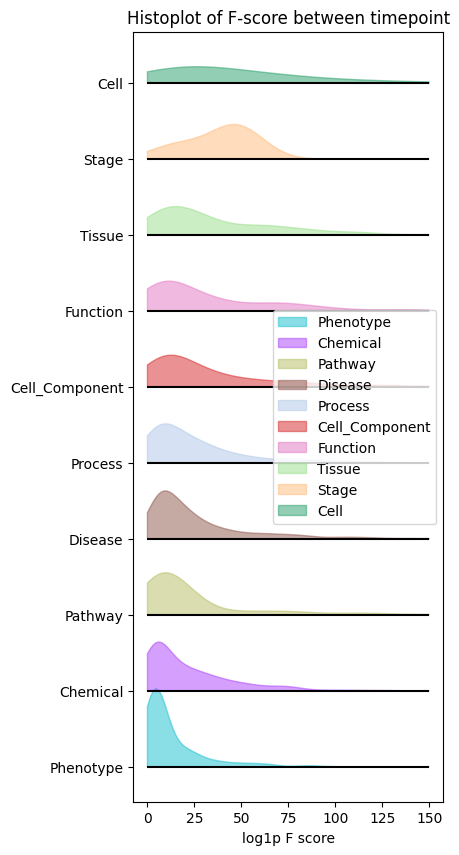

In [54]:
ret = {x:y['path.2.match_count'] for x, y in df_count_filtered.groupby('path.2.type')}
import numpy as np

fig = multi_histo_plot(ret, xmin=0, xmax=150)

In [57]:
fig.savefig('./result_data/Figure/histoplot_DD.pdf')

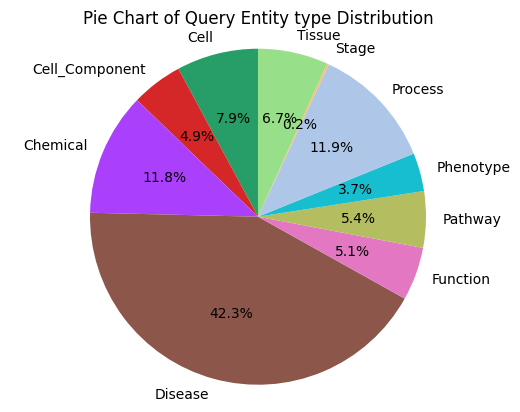

In [58]:
import matplotlib.pyplot as plt

# 准备数据
sizes = [len(ret[x]) for x in ret.keys()]
labels = [x for x in ret.keys()]
# 突出显示 'Hogs' 部分
#explode = (0, 0.1, 0, 0)  
# 自定义颜色
colors = [label2color["KG_"+x] for x in ret.keys()]

# 绘制饼状图，添加数据标签和百分比
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# 设置图形为圆形
plt.axis('equal')  

# 添加标题
plt.title('Pie Chart of Query Entity type Distribution')

# 显示图形
plt.savefig('./result_data/Figure/piechart_DD.pdf')

## rank chemicals related to diseases
use cosine similarity to find potential drugs for disease

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns

In [63]:
adata_graph_chemical = adata_graph[adata_graph.obs['cellstate'] == 'KG_Chemical']
adata_graph_covid = adata_graph[adata_graph.obs['cellstate'] == 'KG_Disease']


emb1 = adata_graph_chemical.X
emb2 = adata_graph_covid.X
dist = cosine_similarity(emb1, emb2)

dist_map = pd.DataFrame(dist)
dist_map.columns = adata_graph_covid.obs_names
dist_map.index = adata_graph_chemical.obs_names

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


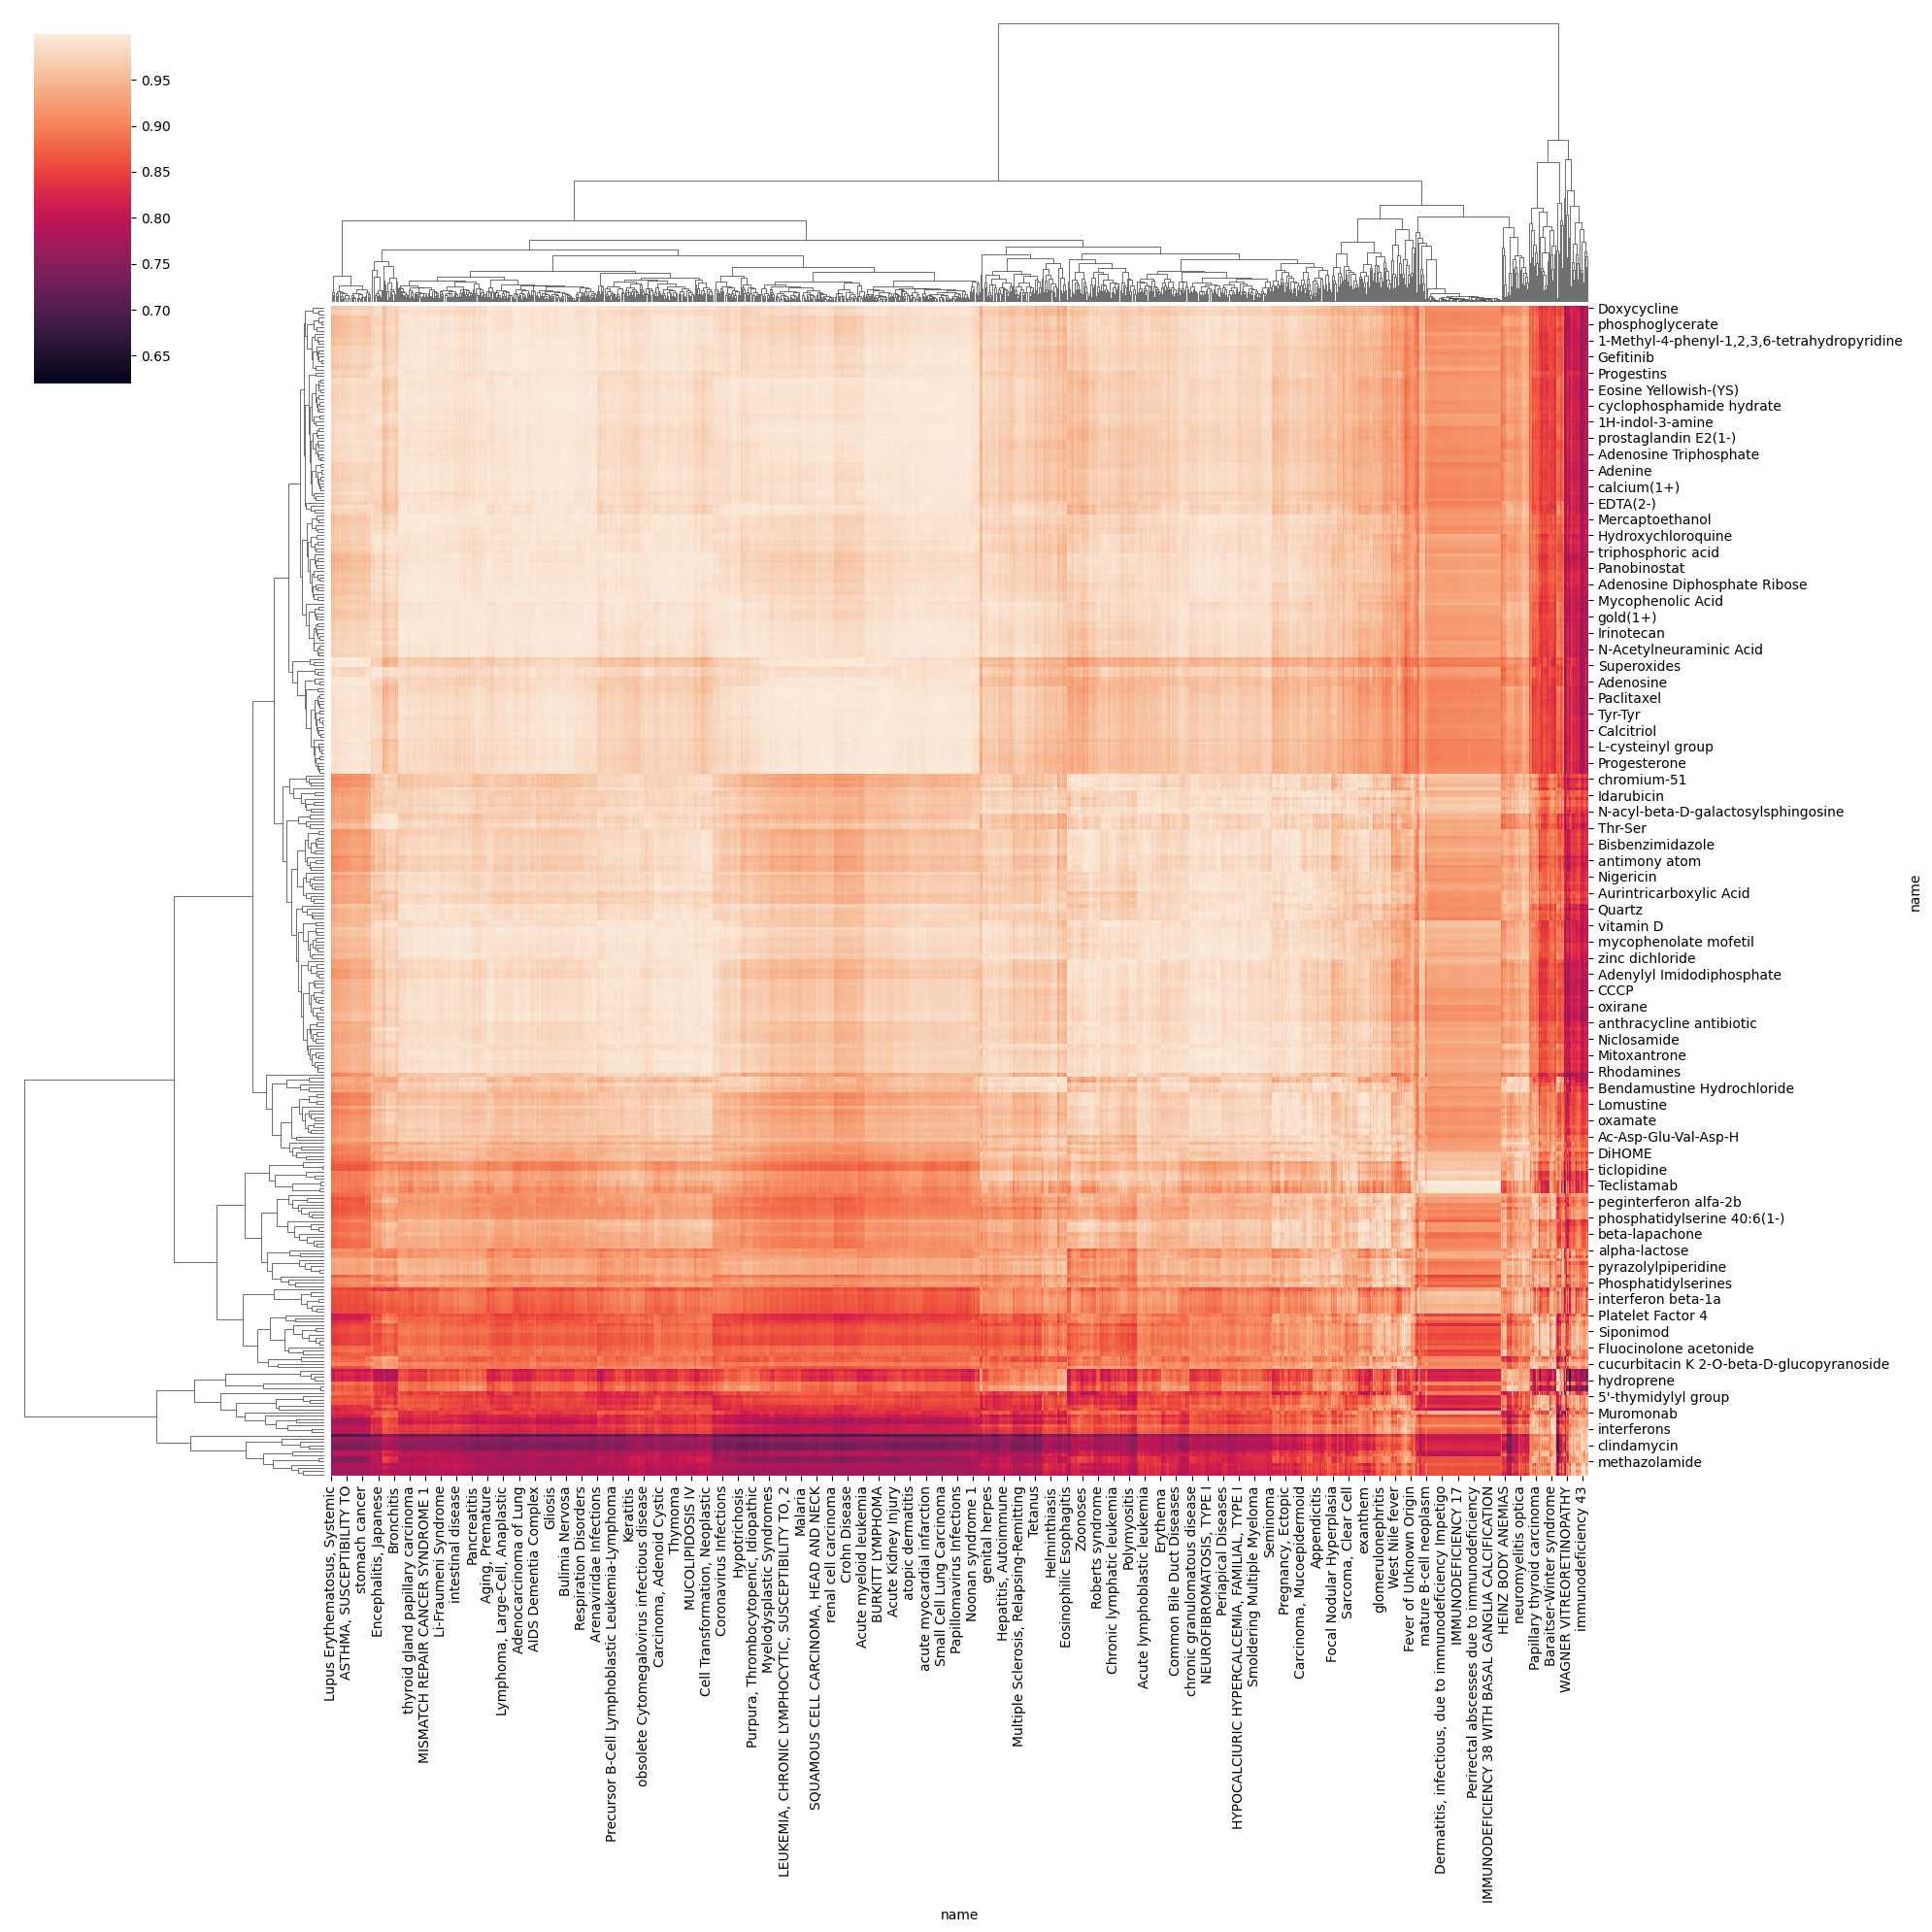

In [64]:
sns.clustermap(dist_map, figsize=(20, 20))

### to show a specific result, we can also visualize the top 30 chemicals and disease

In [80]:
df_count_filtered.loc[df_count_filtered['path.2.name'] == 'COVID-19']

,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
2669,"[ISG15, CD38, EPSTI1, COPB2, MYOM2, CD3D, IL18...",MESH:D000086382,COVID-19,Disease,112,3117,5.017183e-12


In [79]:
df_count_filtered.loc[df_count_filtered['path.2.type'] == 'Disease'].sort_values('pvalue').head(50)

,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
6954,"[BCL2, TRAC, CD38, CD247, MYOM2, CD3E, CD3D, T...",OMIM:MTHU008966,Leukemia,Disease,154,78,9.733143e-203
7153,"[BCL2, TRAC, ISG15, CD38, PIM1, IL32, CD3E, CD...",OMIM:MTHU007429,Lymphoma,Disease,127,22,1.233203e-194
2043,"[BCL2, TRAC, IKZF3, SYK, CD53, CD38, CD3D, TNF...",OMIM:MTHU019696,B-cell lymphoma,Disease,107,22,1.135202e-162
9582,"[HLA-C, TYMP, ISG15, CD53, CD38, IL32, MYOM2, ...",OMIM:MTHU036411,Psoriasis,Disease,86,11,1.420440e-137
1347,"[BCL2, TRAC, RPS14, RPL18, RPL9, RPL5, SAMD9, ...",OMIM:MTHU007776,Acute myeloid leukemia,Disease,92,78,1.197485e-112
1612,"[RPL5, HBA2, IER2, TRIP12, MYOM2, CD3D, TNFSF1...",OMIM:MTHU002606,Anemia,Disease,68,46,9.699796e-89
11030,"[BCL2, TRAC, TYMP, CD38, CD3E, CD3D, RUNX3, CA...",OMIM:MTHU070646,T-cell lymphoma,Disease,33,22,1.146813e-44
11025,"[BCL2, TRAC, JAK1, RPL5, CD53, CD38, CD3E, CD3...",OMIM:MTHU068526,T-cell acute lymphoblastic leukemia,Disease,37,78,5.690682e-37
4143,"[ISG15, CD3D, CASP1, CALR, NCOA4, AHNAK, LAP3,...",MESH:D004194,Disease,Disease,106,1430,1.026416e-31
2790,"[TYMP, ISG15, CD53, COPB2, IL32, RSAD2, CD3D, ...",MESH:D002277,Carcinoma,Disease,155,3243,7.448131e-25


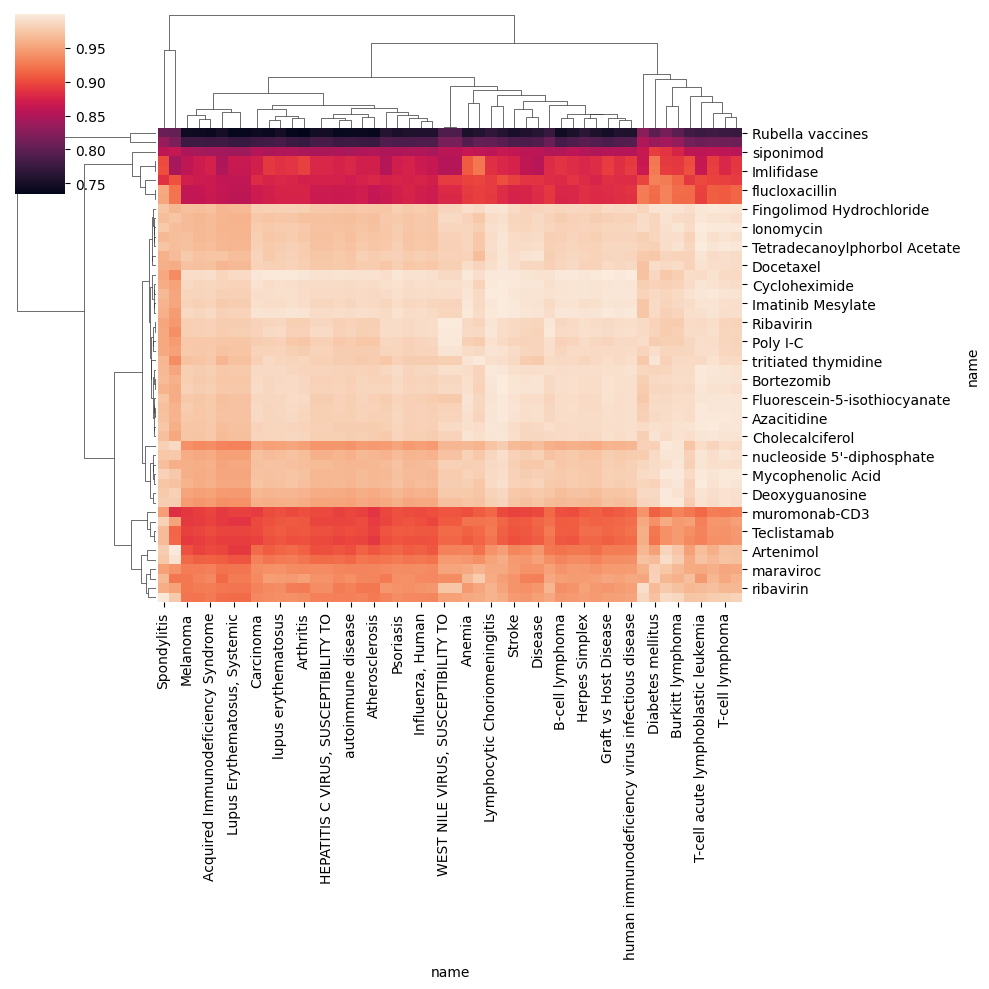

In [81]:
sub_set_disease = df_count_filtered.loc[df_count_filtered['path.2.type'] == 'Disease'].sort_values('pvalue').head(50)['path.2.name']
sub_set_chemical = df_count_filtered.loc[df_count_filtered['path.2.type'] == 'Chemical'].sort_values('pvalue').head(50)['path.2.name']

dist_map_sub = dist_map.loc[sub_set_chemical, sub_set_disease]
sns.clustermap(dist_map_sub, figsize=(20, 20))

## Analysis of COVID-19

In [67]:
df_covid = dist_map[['COVID-19']].sort_values('COVID-19', ascending=False)
df_covid.columns = ['cosine_similiarity']

we can also calculate the Euclidean distance between chemicals and diseases

In [68]:
import numpy as np

eu_dist = np.array([ np.linalg.norm(emb1 - x, axis=1) for x in emb2]).T

eu_dist_map = pd.DataFrame(eu_dist)
eu_dist_map.columns = adata_graph_covid.obs_names
eu_dist_map.index = adata_graph_chemical.obs_names

df_covid['euclidean_distance'] = eu_dist_map['COVID-19']
df_covid.head()

,cosine_similiarity,euclidean_distance
name,,
primary amino group,0.997762,0.016841
Superoxides,0.996272,0.024487
Disulfides,0.993997,0.028361
Adenosine,0.993938,0.038047
retinoic acid,0.993763,0.043013


Text(0, 0.5, 'euclidean distance')

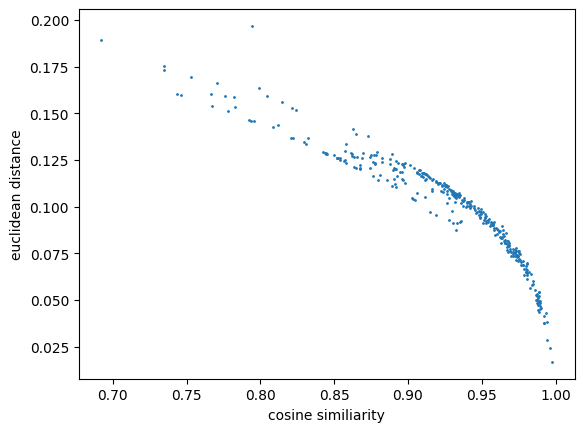

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(df_covid['cosine_similiarity'], df_covid['euclidean_distance'], s=1)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('euclidean distance')

## Compare predicted potential drugs with real drug for COVID-19

In [70]:
# abort

drug_df = pd.read_csv('./data/drug_df.csv', index_col=0)

In [26]:
drug_df = BRICK.qr.query_neighbor(['COVID-19'], source_entity_type='Disease', target_entity_type='Chemical', relation='pharmaco_effect_on')
drug_df.head()

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,"['Undef', 'Undef', 'Undef']","['CLINICALTRAILS:NCT04885530', 'CLINICALTRAILS...",3,"['pharmaco_effect_on', 'pharmaco_effect_on', '...",pharmaco_effect_on,A STEROID with GLUCOCORTICOID RECEPTOR activit...,MESH:D000068298,Fluticasone,Undef,Chemical
1,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,['Undef'],['CLINICALTRAILS:NCT04729491'],1,['pharmaco_effect_on'],pharmaco_effect_on,A 5-ALPHA-REDUCTASE INHIBITOR that is reported...,MESH:D000068538,Dutasteride,Undef,Chemical
2,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,['Undef'],['CLINICALTRAILS:NCT04631536'],1,['pharmaco_effect_on'],pharmaco_effect_on,A cardioselective ADRENERGIC BETA-1 RECEPTOR A...,MESH:D000068577,Nebivolol,Undef,Chemical
3,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,"['Undef', 'Undef', 'Undef', 'Undef']","['CLINICALTRAILS:NCT04488081', 'CLINICALTRAILS...",4,"['pharmaco_effect_on', 'pharmaco_effect_on', '...",pharmaco_effect_on,A pyrazole derivative and selective CYCLOOXYGE...,MESH:D000068579,Celecoxib,Undef,Chemical
4,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,['Undef'],['CLINICALTRAILS:NCT04484493'],1,['pharmaco_effect_on'],pharmaco_effect_on,A pregnadienediol derivative ANTI-ALLERGIC AGE...,MESH:D000068656,Mometasone Furoate,Undef,Chemical


In [71]:
real_drugs = list(drug_df['path.2.name'])
df_covid['is_real_drug'] = [x in real_drugs for x in df_covid.index]

df_covid.head(15)

,cosine_similiarity,euclidean_distance,is_real_drug
name,,,
primary amino group,0.997762,0.016841,False
Superoxides,0.996272,0.024487,False
Disulfides,0.993997,0.028361,False
Adenosine,0.993938,0.038047,True
retinoic acid,0.993763,0.043013,False
N(2)-L-lysino group,0.992515,0.041407,False
Polyethylene Glycols,0.992441,0.037493,False
Cisplatin,0.992347,0.037712,False
Paclitaxel,0.990273,0.045570,False


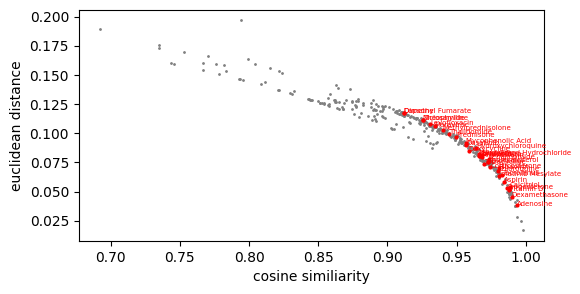

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,3))

df_covid_real = df_covid.loc[df_covid['is_real_drug']]
df_covid_new_find = df_covid.loc[~df_covid['is_real_drug']]
ax.scatter(df_covid_new_find['cosine_similiarity'], df_covid_new_find['euclidean_distance'], s=1, color='grey')
ax.scatter(df_covid_real['cosine_similiarity'], df_covid_real['euclidean_distance'], s=4, color='red')

for x, row in df_covid_real.iterrows():
    ax.text(row['cosine_similiarity'], row['euclidean_distance'], x, color='red', fontsize=5)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('euclidean distance')

fig.savefig('./result_data/Figure/text_rank_AIDD.pdf')

### Visualize the distribution of real drugs and predicted chemicals 

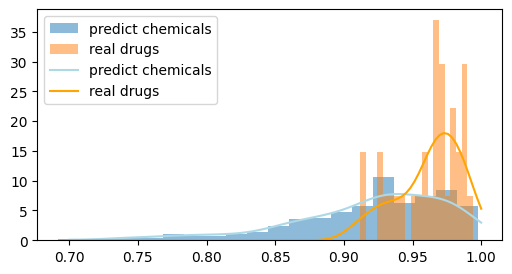

In [86]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(6,3))


x = np.linspace(0.7, 1, 100)

y_real = gaussian_kde(df_covid_real['cosine_similiarity'])(x)
y_new = gaussian_kde(df_covid_new_find['cosine_similiarity'])(x)
ax.hist(df_covid_new_find['cosine_similiarity'], density=True, bins = 20, alpha=0.5, label='predict chemicals')
ax.hist(df_covid_real['cosine_similiarity'], density=True, bins = 20,  alpha=0.5, label='real drugs')

ax.plot(x, y_new, label='predict chemicals', color = 'lightblue')
ax.plot(x, y_real, label='real drugs', color = 'orange')
ax.legend()

fig.savefig('./result_data/Figure/hist_rank_AIDD.pdf')

## Dynamic change During representive learning 

In [60]:
model = BRICK.emb.GRACE_model(nxg, device='cuda:1', lr=0.001)

In [61]:
epoch_layers = {}
for i in range(100):
    model.fit(epoches=1)
    epoch_layers[f'{i*10}_epoch'] = model.get_embbedding()

(T):   0%|          | 0/1 [00:00<?, ?it/s]/home/share/huadjyin/home/s_caolei2/yanbang/qiuping/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
(T): 100%|██████████| 1/1 [00:00<00:00, 12.23it/s, loss=8.51]


In [62]:
import numpy as np

eu_dist = np.array([ np.linalg.norm(emb1 - x, axis=1) for x in emb2]).T

eu_dist_map = pd.DataFrame(eu_dist)
eu_dist_map.columns = adata_graph_covid.obs_names
eu_dist_map.index = adata_graph_chemical.obs_names

df_covid['euclidean_distance'] = eu_dist_map['COVID-19']

Text(0, 0.5, 'euclidean distance')

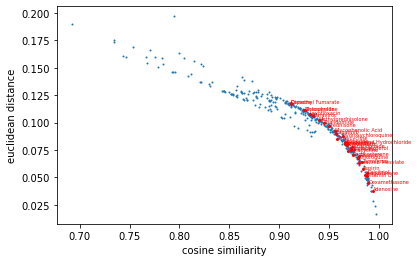

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


select_y = 'euclidean_distance'
df_covid_real = df_covid.loc[df_covid['is_real_drug']]
df_covid_new_find = df_covid.loc[~df_covid['is_real_drug']]
ax.scatter(df_covid_new_find['cosine_similiarity'], df_covid_new_find[select_y], s=1)
ax.scatter(df_covid_real['cosine_similiarity'], df_covid_real[select_y], s=4, color='red')

for x, row in df_covid_real.iterrows():
    ax.text(row['cosine_similiarity'], row[select_y], x, color='red', fontsize=5)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('euclidean distance')

In [65]:
adata_graph = model.get_result(umap=False)
for x, y in epoch_layers.items():
    adata_graph.layers[x] = y



/home/share/huadjyin/home/s_caolei2/yanbang/qiuping/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
/home/share/huadjyin/home/s_caolei2/yanbang/qiuping/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [74]:
adata_graph

AnnData object with n_obs × n_vars = 10176 × 32
    obs: 'name', 'type', 'cellstate'
    uns: 'neighbors', 'umap', 'cellstate_colors'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [67]:
adata_graph.write(f'./result_data/adata_graph_{select_celltype}.h5ad')

In [68]:
adata_graph_chemical = adata_graph[adata_graph.obs['type'] == 'KG_Chemical']
adata_graph_covid = adata_graph[adata_graph.obs['name'] == 'COVID-19']


for epoch in range(100):
    emb1 = adata_graph_chemical.layers[f'{epoch*10}_epoch']
    emb2 = adata_graph_covid.layers[f'{epoch*10}_epoch']
    #dist = np.array([ np.linalg.norm(emb1 - x, axis=1) for x in emb2]).T
    dist = cosine_similarity(emb1, emb2)

    dist_map_tmp = pd.DataFrame(dist)
    dist_map_tmp.index = adata_graph_chemical.obs_names
    df_covid[f'{epoch*10}_epoch'] = dist_map_tmp[0]

/tmp/ipykernel_4119423/940200255.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_covid[f'{epoch*10}_epoch'] = dist_map_tmp[0]
/tmp/ipykernel_4119423/940200255.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_covid[f'{epoch*10}_epoch'] = dist_map_tmp[0]


In [69]:
xtick = [10*i for i in range(100)]
df_covid_drug = df_covid[[f'{x}_epoch' for x in xtick]].T

### calculate drug trend

use pearson correlation to indicate the tendency of similiarity to COVID during training epoches

In [70]:
from scipy.stats import pearsonr, spearmanr

pearson_dict = {}
for x in df_covid_drug:
    pearson_dict[x] = spearmanr(df_covid_drug[x], xtick).correlation
pearson_df = pd.DataFrame([pearson_dict]).T
df_covid['pearson'] = pearson_df[0]

Text(0, 0.5, 'pearson')

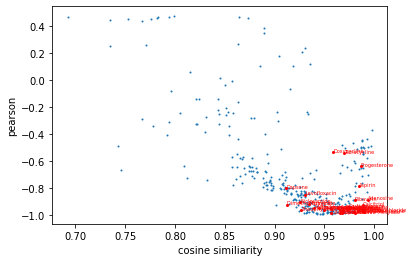

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_covid_real = df_covid.loc[df_covid['is_real_drug']]
df_covid_new_find = df_covid.loc[~df_covid['is_real_drug']]
ax.scatter(df_covid_new_find['cosine_similiarity'], df_covid_new_find['pearson'], s=1)
ax.scatter(df_covid_real['cosine_similiarity'], df_covid_real['pearson'], s=4, color='red')

for x, row in df_covid_real.iterrows():
    ax.text(row['cosine_similiarity'], row['pearson'], x, color='red', fontsize=5)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('pearson')

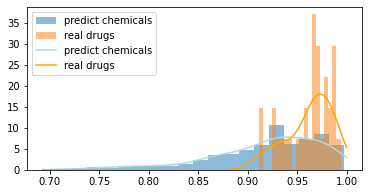

In [72]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(6,3))


x = np.linspace(0.7, 1, 100)

y_real = gaussian_kde(df_covid_real['cosine_similiarity'])(x)
y_new = gaussian_kde(df_covid_new_find['cosine_similiarity'])(x)
ax.hist(df_covid_new_find['cosine_similiarity'], density=True, bins = 20, alpha=0.5, label='predict chemicals')
ax.hist(df_covid_real['cosine_similiarity'], density=True, bins = 20,  alpha=0.5, label='real drugs')

ax.plot(x, y_new, label='predict chemicals', color = 'lightblue')
ax.plot(x, y_real, label='real drugs', color = 'orange')
ax.legend()

In [ ]:
sc.pp.neighbors(adata_graph)